In [2]:
import os
import sys
import pandas as pd
import geopandas as gpd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    auc,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

sys.path.append("../utils")


In [3]:
data = pd.read_csv(
    "/capstone/wildfire_prep/data/PUZZLE_PIECES/assembled_puzzle.csv"
).drop(columns="basemap_id")

In [4]:
print(data.shape)
print(data.columns)
data.head()

(67580, 4005)
Index(['inspection_id', 'X_0', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8',
       ...
       'X_3994', 'X_3995', 'X_3996', 'X_3997', 'X_3998', 'X_3999',
       'maj_landcover_code_x', 'maj_landcover_code_y', 'status',
       'structure_code'],
      dtype='object', length=4005)


,inspection_id,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_3994,X_3995,X_3996,X_3997,X_3998,X_3999,maj_landcover_code_x,maj_landcover_code_y,status,structure_code
0,1,0.054892,0.0,0.015004,0.0,0.238797,0.000466,0.0,0.055266,0.005605,...,0.052267,2.742807,1.274291,1.905394,4.261047,2.500061,304.0,557,0,100
1,2,0.024470,0.0,0.003108,0.0,0.129467,0.000687,0.0,0.034108,0.012225,...,0.232065,2.272318,1.205103,1.661454,3.457836,2.098205,304.0,304,0,101
2,3,0.271383,0.0,0.126712,0.0,0.976787,0.043854,0.0,0.528058,0.124882,...,0.000000,3.815154,1.246298,2.504779,6.486201,3.454411,303.0,303,0,101
3,4,0.097084,0.0,0.037654,0.0,0.549639,0.001046,0.0,0.240636,0.017580,...,0.016924,3.105121,1.228030,2.112541,5.209030,2.868551,39.0,304,0,100
4,5,0.041986,0.0,0.008531,0.0,0.253195,0.001353,0.0,0.036694,0.002605,...,0.040597,2.683573,1.311833,1.853227,4.251881,2.500635,304.0,304,0,101


## Downsample Majority Class Approach


In [5]:
# Pull out majority/minority from data
compliant = data[data.status == 0]
non_compliant = data[data.status == 1]

# Downsample majority to be 3x minority's size
n_majority_desired = len(non_compliant) * 3
compliant_down = compliant.sample(n=n_majority_desired, random_state=42)

# Reassemble and shuffle
data_downsampled_maj = (
    pd.concat([non_compliant, compliant_down])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

# Split back into X_train and y_train, downsampled
X = data_downsampled_maj.drop("status", axis=1)
y = data_downsampled_maj["status"]

downsample_data_ids = X.inspection_id

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Dropping inspection_id, to prevent overfitting to this ID.
X_train = X_train.drop(columns="inspection_id")
# Do the same for X_test, so that the datasets align
X_test = X_test.drop(columns="inspection_id")

# Balance check
print("Shapes:")
print("  X_train:", X_train.shape)
print("  y_train:", y_train.shape)
print("  X_test: ", X_test.shape)
print("  y_test: ", y_test.shape)

print("\nTrain distribution after downsampling:")
print(y_train.value_counts(normalize=True))

X_train


Shapes:
  X_train: (1337, 4003)
  y_train: (1337,)
  X_test:  (335, 4003)
  y_test:  (335,)

Train distribution after downsampling:
status
0    0.750187
1    0.249813
Name: proportion, dtype: float64


,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_3993,X_3994,X_3995,X_3996,X_3997,X_3998,X_3999,maj_landcover_code_x,maj_landcover_code_y,structure_code
263,0.905372,0.0,0.463061,0.000000,1.886351,0.218102,0.0,0.846962,0.314425,0.072376,...,1.990615,0.024028,5.085317,1.595800,3.121448,8.630460,4.673191,582.0,583,100
1174,0.684678,0.0,0.411536,0.000000,1.702152,0.190052,0.0,0.884239,0.345773,0.061749,...,1.979469,0.000000,4.910191,1.435695,3.066463,8.364141,4.439219,303.0,557,102
852,0.565098,0.0,0.244072,0.000000,1.397524,0.053152,0.0,0.507633,0.047321,0.004118,...,1.675718,0.000000,4.271287,1.572340,2.638462,7.250310,3.956442,303.0,582,102
1377,0.551114,0.0,0.380738,0.008085,1.375016,0.255696,0.0,0.667960,0.307508,0.101963,...,1.812671,0.042046,4.371453,1.454859,2.777266,7.452064,4.018713,303.0,581,101
1000,0.577466,0.0,0.383065,0.000237,1.404185,0.225870,0.0,0.861246,0.377799,0.100622,...,1.855773,0.002151,4.450581,1.315709,2.852853,7.692123,3.993739,582.0,581,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1560,0.761893,0.0,0.361810,0.011677,1.540986,0.198266,0.0,0.647898,0.297218,0.108509,...,1.767104,0.022461,4.505622,1.574185,2.768298,7.620576,4.148877,557.0,582,102
275,0.567275,0.0,0.386197,0.000000,1.351602,0.208301,0.0,0.792596,0.257522,0.025489,...,1.796558,0.065397,4.307644,1.354678,2.751070,7.412181,3.893932,39.0,581,101
701,0.459184,0.0,0.220497,0.000000,1.271045,0.104797,0.0,0.578228,0.136149,0.011004,...,1.751961,0.000827,4.167685,1.395118,2.656357,7.113483,3.831665,583.0,581,102
425,0.605536,0.0,0.298521,0.003151,1.470883,0.163972,0.0,0.562979,0.151078,0.071432,...,1.803491,0.033881,4.416279,1.568747,2.749253,7.478241,4.158309,583.0,556,100


## Upsample Minority Class Approach


In [6]:
# Pull out majority/minority from data
compliant = data[data.status == 0]
non_compliant = data[data.status == 1]

# Upsample minority to match majority’s size
n_minority_desired = int(len(compliant) / 3)

non_compliant_upsampled = non_compliant.sample(
    n=n_minority_desired, replace=True, random_state=42
)

# Reassemble and shuffle train set
data_upsampled_min = (
    pd.concat([compliant, non_compliant_upsampled])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

# Split back into X_train y_train, upsampled
X = data_upsampled_min.drop("status", axis=1)
y = data_upsampled_min["status"]

# Save inspection_ids from the data, in case we need them later
upsample_data_ids = X.inspection_id

# split data, as usual. 20% test data split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Dropping inspection_id, to prevent overfitting to this ID.
X_train = X_train.drop(columns="inspection_id")
# Do the same for X_test, so that the datasets align
X_test = X_test.drop(columns="inspection_id")

# Check majority/minority sizes
print(f"Shape of compliant:", compliant.shape)
print(f"Shape of non-compliant:", non_compliant.shape)

print(f"N_minority desired:", int(len(compliant) / 3))
print(f"Shape of non-compliant upsampled:", non_compliant_upsampled.shape)
print(f"Shape of upsampled training data:", data_upsampled_min.shape)

print("Shapes:")
print(" Upsampled X_train:", X_train.shape)
print(" Upsampled y_train:", y_train.shape)
print(" Upsampled X_test: ", X_test.shape)
print(" Upsampled y_test: ", y_test.shape)

print("\nTrain distribution after up-sampling:")
print(y_train.value_counts(normalize=True))

X_train

Shape of compliant: (67162, 4005)
Shape of non-compliant: (418, 4005)
N_minority desired: 22387
Shape of non-compliant upsampled: (22387, 4005)
Shape of upsampled training data: (89549, 4005)
Shapes:
 Upsampled X_train: (71639, 4003)
 Upsampled y_train: (71639,)
 Upsampled X_test:  (17910, 4003)
 Upsampled y_test:  (17910,)

Train distribution after up-sampling:
status
0    0.749997
1    0.250003
Name: proportion, dtype: float64


,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_3993,X_3994,X_3995,X_3996,X_3997,X_3998,X_3999,maj_landcover_code_x,maj_landcover_code_y,structure_code
12408,0.234782,0.0,0.199884,0.000000,1.001444,0.084475,0.0,0.578815,0.129434,0.002561,...,1.721150,0.002369,3.877031,1.290927,2.562295,6.630246,3.508047,304.0,582,101
20205,0.366751,0.0,0.281059,0.002908,0.918135,0.174326,0.0,0.580405,0.332229,0.070729,...,1.683923,0.124357,3.752400,1.248382,2.499306,6.283739,3.311795,581.0,582,102
703,0.457277,0.0,0.369603,0.005987,1.308423,0.265479,0.0,0.784860,0.353869,0.091935,...,1.848032,0.030319,4.295269,1.342975,2.787861,7.416942,3.905155,581.0,582,102
82084,0.153808,0.0,0.138017,0.000350,0.790564,0.077879,0.0,0.474470,0.096333,0.001487,...,1.672683,0.030413,3.548604,1.219127,2.404826,6.039326,3.230875,582.0,581,102
37554,0.699233,0.0,0.421262,0.000017,1.419048,0.202724,0.0,0.738152,0.221872,0.060353,...,1.677784,0.060105,4.242943,1.475194,2.649927,7.264755,3.847027,NaN,581,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33033,1.071834,0.0,0.543664,0.006707,1.946876,0.272266,0.0,0.883787,0.285899,0.107478,...,1.805040,0.058002,4.943869,1.649684,2.956631,8.510991,4.543437,304.0,582,102
59193,0.033401,0.0,0.042321,0.000000,0.307716,0.038443,0.0,0.176424,0.059110,0.003028,...,1.540857,0.174560,2.804569,1.154118,2.044071,4.485913,2.573127,582.0,582,102
59285,0.147926,0.0,0.064140,0.000000,0.295015,0.021248,0.0,0.203973,0.107248,0.001626,...,1.320537,0.143011,2.628198,1.158219,1.844971,4.166584,2.308218,581.0,581,102
88866,0.429087,0.0,0.311793,0.000000,1.507914,0.255528,0.0,0.947954,0.354570,0.027585,...,2.047005,0.002659,4.662066,1.246801,3.045829,8.126602,4.264431,583.0,556,102


In [7]:
# Make code chunk to do both upsampling and downsampling:
# Downsample majority and then upsample minority, all in the same data

## Random Forest Classifier Model


In [8]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Length of y_pred:", len(y_pred))
print("Accuracy:", accuracy)


Length of y_pred: 17910
Accuracy: 0.9998883305415969


In [10]:
param_dist = {
    "max_depth": randint(1, 20),
    "min_samples_leaf": [1, 5, 10, 20],
    "max_features": ["sqrt", "log2", 0.2, 0.5],
    # "class_weight": [None, "balanced", "balanced_subsample"],
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1, bootstrap=True)

halving_search = HalvingRandomSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    resource="n_estimators",
    min_resources=20,
    max_resources=200,
    factor=3,
    cv=2,
    scoring="precision",
    n_jobs=1,
    verbose=1,
)

halving_search.fit(X_train, y_train)

best_rf = halving_search.best_estimator_


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 20
Fitting 2 folds for each of 10 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 2 folds for each of 4 candidates, totalling 8 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 2 folds for each of 2 candidates, totalling 4 fits


In [11]:
best_params = halving_search.best_params_

best_rf = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1,
    bootstrap=True
)

best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)

y_scores = best_rf.predict_proba(X_test)[:, 1]

print(best_params)


In [ ]:
# # RandomizedSeacrchCV cell
# param_dist = {
#     "n_estimators": randint(50, 500),
#     "max_depth": randint(1, 20),
#     "class_weight": [None, "balanced", "balanced_subsample"],
# }

# param_dist.update(
#     {
#         "min_samples_leaf": [1, 5, 10, 20],
#         "max_features": ["sqrt", "log2", 0.2, 0.5],
#     }
# )

# rf = RandomForestClassifier(
#     random_state=42,
#     n_jobs=-1,
#     # ,
#     # max_samples = 0.7,    # added
#     # bootstrap = True      # added
# )
# # random search method
# rand_search = RandomizedSearchCV(
#     rf,
#     param_distributions = param_dist,
#     n_iter = 20,      # increased from 10, originally 20
#     cv = 3,           # increased from 2, originally 3
#     scoring = "precision",
#     #scoring = 'recall',
#     refit = True,
#     n_jobs = 1,
#     verbose = 1,
# )
# rand_search.fit(X_train, y_train)

# best_rf = rand_search.best_estimator_

# y_scores = best_rf.predict_proba(X_test)[:, 1]


In [ ]:
# TESTING PRECISION
# greatest precision achievable is 0.5, default


# 6 Quick diagnostic of your score distribution
print("Probability range:", y_scores.min(), "to", y_scores.max())
print("Positives at 0.5 cutoff:", (y_scores >= 0.5).sum())

# 7 Try a few fixed thresholds
for thresh in np.arange(0.50, 0.65, 0.01):
    preds = (y_scores >= thresh).astype(int)
    print(f"\nThreshold {thresh:.001f} → Positives = {preds.sum()}")
    print(" Precision:", precision_score(y_test, preds))
    print(" Recall:   ", recall_score(y_test, preds))

# 8 Precision–Recall curve based threshold search
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
precisions = precisions[:-1]  # align lengths with thresholds

# What’s the best precision you can actually hit?
best_possible_precision = precisions.max()
print("\nBest achievable precision:", best_possible_precision)

# Now find the first threshold that reaches ≥0.6, if any
target = 0.6
valid = np.where(precisions >= target)[0]

if valid.size:
    best_idx = valid[0]
    best_thresh = thresholds[best_idx]
    print(f"Threshold for ≥{target:.2f} precision:", best_thresh)
    y_pred_opt = (y_scores >= best_thresh).astype(int)
    print(" Precision:", precision_score(y_test, y_pred_opt))
    print(" Recall:   ", recall_score(y_test, y_pred_opt))
else:
    print(
        f"No threshold yields ≥{target:.2f} precision. "
        f"Falling back to best achievable precision of "
        f"{best_possible_precision:.3f}."
    )
    # you could pick the threshold for that best precision:
    best_idx = np.argmax(precisions)
    best_thresh = thresholds[best_idx]
    print("  Using threshold:", best_thresh)
    y_pred_opt = (y_scores >= best_thresh).astype(int)
    print("  Precision:", precision_score(y_test, y_pred_opt))
    print("  Recall:   ", recall_score(y_test, y_pred_opt))

In [31]:
feature_importances = pd.Series(
    best_rf.feature_importances_, index=X_train.columns
).sort_values(ascending=False)

Accuracy: 0.9683975432719152
Precision: 0.9992341077355119
Recall: 0.8742461469734197


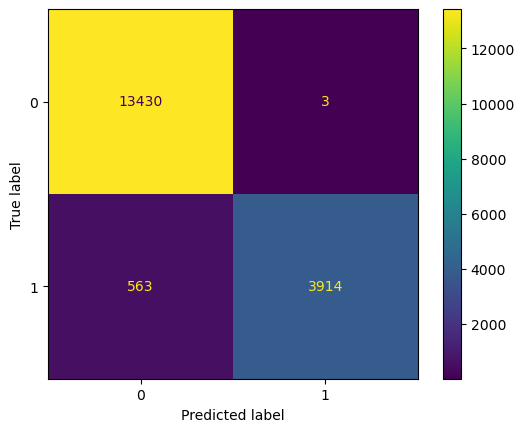

In [32]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();


In [1]:
# X_test["mismatch"] = X_test["status"] != X_data["predicted_status"]

# num_mismatch = X_test["mismatch"].sum()
# pct_mismatch = X_test["mismatch"].mean()

# print(f"Total mismatches: {num_mismatch}")
# print(f"Error rate:     {pct_mismatch:.2%}")


NameError: name 'X_test' is not defined

In [33]:
# Testing new Thresholds Chunk
# precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# new_thresh = 0.59
# y_pred_adj = (y_scores >= new_thresh).astype(int)
# print(classification_report(y_test, y_pred_adj))

# cm = confusion_matrix(y_test, y_pred_adj)


# plt.plot(thresholds, precisions[:-1], label="Precision")
# plt.plot(thresholds, recalls[:-1], label="Recall")
# plt.xlabel("Threshold")
# plt.legend()
# plt.show()


# ConfusionMatrixDisplay(confusion_matrix=cm).plot()


Feature importances:
 maj_landcover_code_y    0.001952
structure_code          0.001117
X_814                   0.001036
X_3007                  0.000994
X_1628                  0.000957
dtype: float64


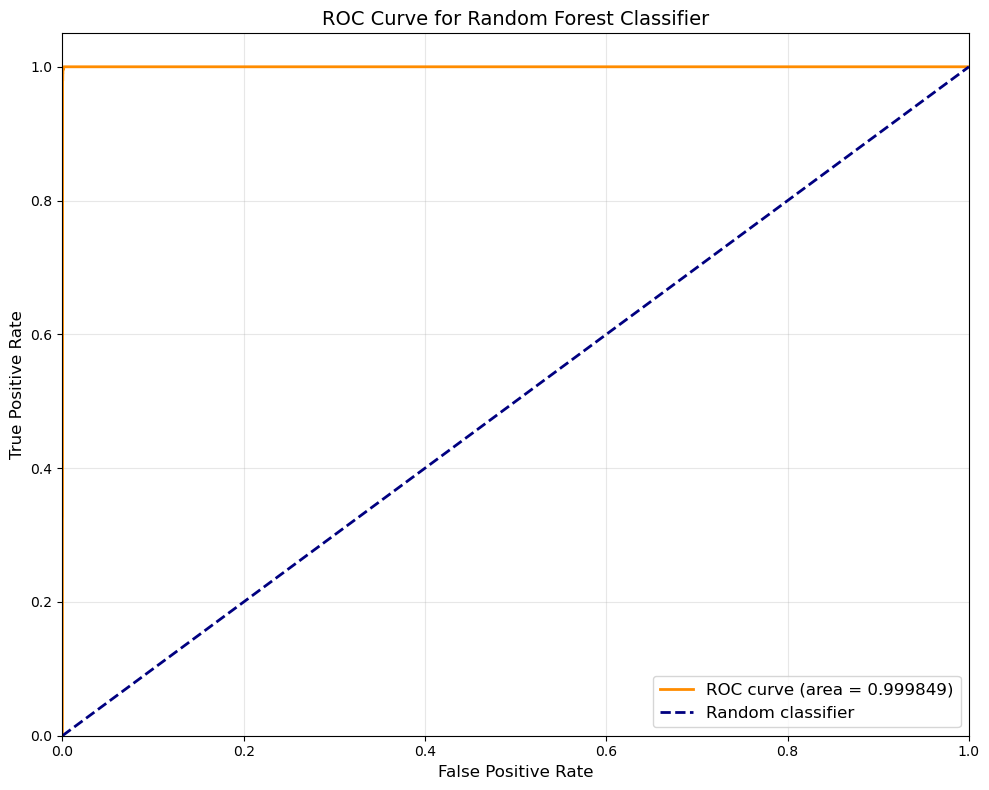

ROC AUC Score: 0.9998


In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

print(f"Feature importances:\n", feature_importances.head())

# Generate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Create the plot
plt.figure(figsize=(10, 8))

# Plot ROC curve
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.6f})")

# Plot baseline
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random classifier")

# Style the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve for Random Forest Classifier", fontsize=14)
plt.legend(loc="lower right", fontsize=12)

# Add grid
plt.grid(alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()

# Print numeric results for reference
print(f"ROC AUC Score: {roc_auc:.4f}")


5/20/25 - ROC area of .565: Downsampling approach, 20% test data, majority downsampled to make up 75% of data.
Length of y_pred : 335
Accuracy : .72

Conf matrix:
Accuracy: 0.7492537313432835
Precision: 0.0
Recall: 0.0

Features:
maj_landcover_code_y 0.027539
structure_code 0.010202
X_603 0.008226
X_2659 0.007409
X_3188 0.007161

rand_search scoring = precision


5/20/25 - ROC area of .99. Upsampled minority approach, 20% test data, minority upsampled to be 25% if total data. y_pred length: 17910, accuracy: .99
Conf matrix : Accuracy: 0.8551647124511446
Precision: 0.9989401165871754
Recall: 0.42104087558633013

Features: maj_landcover_code_y 0.012858
structure_code 0.005593
X_3007 0.002352
X_814 0.001987
X_2172 0.001817

rand_search scoring = precision
